## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [2]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [3]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [4]:
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


In [28]:
print(text[642:660])



  ii

  when for


### Data loading: "Евгений Онегин"


In [3]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2020-05-10 19:02:32--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.244.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.244.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.1s    

2020-05-10 19:02:33 (2.25 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here


Put all the characters, that you've seen in the text, into variable `tokens`.

In [16]:
tokens = sorted(set(out))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [25]:
# dict <index>:<char>
# Your great code here

# dict <char>:<index>
# Your great code here

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [9]:
tokens = set(text)
NUM_TOKENS=len(tokens)
print(len(tokens))
tokens = list(tokens)

38


In [26]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}
print(token_to_id)

{'s': 0, 'o': 1, '-': 2, 'u': 3, 'd': 4, ')': 5, 't': 6, ';': 7, 'r': 8, 'n': 9, ',': 10, 'q': 11, '!': 12, 'z': 13, '(': 14, 'y': 15, '?': 16, 'a': 17, 'i': 18, 'j': 19, 'f': 20, 'w': 21, '.': 22, 'l': 23, 'c': 24, 'x': 25, 'g': 26, 'h': 27, 'b': 28, 'p': 29, "'": 30, 'm': 31, 'e': 32, 'k': 33, ':': 34, 'v': 35, ' ': 36, '\n': 37}


In [11]:
text_in_id = [token_to_id[token] for token in text]

In [12]:
print(text[:10])

  from fai


In [29]:
print(text_in_id[642:660])

[37, 37, 36, 36, 18, 18, 37, 37, 36, 36, 21, 27, 32, 9, 36, 20, 1, 8]


In [33]:
parts = text.split('\n\n')

In [38]:
text_parts = [part for part in parts if len(part) > 10]

In [89]:
MAX_LENGTH = max(map(len, text_parts))

In [90]:
print(MAX_LENGTH)

708


In [91]:
def to_matrix(t_parts, max_len=MAX_LENGTH, pad=token_to_id[' '], dtype='int32', batch_first = True):
    
    parts_ix = np.zeros([len(t_parts), max_len], dtype) + pad

    for i in range(len(t_parts)):
        line_ix = [token_to_id[c] for c in t_parts[i]]
        parts_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        parts_ix = np.transpose(parts_ix)

    return parts_ix

In [92]:
parts_ix = to_matrix(text_parts)

In [93]:
print(parts_ix.shape)

(154, 708)


In [50]:
import torch, torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [15]:
class CharRNNCell(nn.Module):
    def __init__(self, num_tokens=NUM_TOKENS, embedding_size=16, rnn_num_units=64):
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        
        x_and_h = torch.cat([h_prev, x_emb], dim=1)
        h_next = self.rnn_update(x_and_h)
        
        h_next = torch.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        logits = self.rnn_to_logits(h_next)
        
        return h_next, logits
    
    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, requires_grad=True)
        

In [162]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=NUM_TOKENS, emb_size=16, rnn_num_units=128):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
    
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        return next_logits

In [173]:
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
history = []

In [120]:
from torchsummary import summary

In [121]:
summary(model)

Layer (type:depth-idx)                   Param #
├─Embedding: 1-1                         608
├─RNN: 1-2                               5,248
├─Linear: 1-3                            2,470
Total params: 8,326
Trainable params: 8,326
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Embedding: 1-1                         608
├─RNN: 1-2                               5,248
├─Linear: 1-3                            2,470
Total params: 8,326
Trainable params: 8,326
Non-trainable params: 0

In [122]:
from random import sample

In [123]:
batch_ix = to_matrix(sample(text_parts, 32))
batch_ix = torch.LongTensor(batch_ix)

logits = model.forward(batch_ix)
print(logits.shape)

torch.Size([32, 708, 38])


In [124]:
criterion = nn.CrossEntropyLoss()

In [128]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

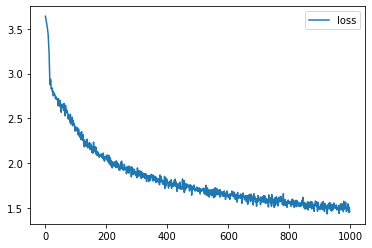

In [174]:
BATCH_SIZE = 8
for i in range(1000):
    opt.zero_grad()
    batch_ix = to_matrix(sample(text_parts, BATCH_SIZE))
    batch_ix = torch.LongTensor(batch_ix)
    
    logits = model(batch_ix)
    
    predictions_logits = logits[:, :-1, :]
    actual_next_tokens = batch_ix[:, 1:]
    loss = criterion(predictions_logits.contiguous().view(-1, NUM_TOKENS), 
                     actual_next_tokens.contiguous().view(-1))
    
    loss.backward()
    opt.step()
    
    history.append(loss.data.numpy())
    if (i+1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [165]:
def generate_sample(char_rnn, seed_phrase=' hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    print(x_sequence)
    hid_state = torch.zeros(1, 64, requires_grad=True)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        print(x_sequence[:, -1].shape, hid_state.shape)
        out = char_rnn(x_sequence[:, i])
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        print(x_sequence.shape, x_sequence, hid_state.shape)
        out = char_rnn(x_sequence[:, -1])
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [175]:
strin = generate_sample(model, seed_phrase=' shall')

tensor([[36,  0, 27, 17, 23, 23]])
torch.Size([1]) torch.Size([1, 64])
torch.Size([1]) torch.Size([1, 64])
torch.Size([1]) torch.Size([1, 64])
torch.Size([1]) torch.Size([1, 64])
torch.Size([1]) torch.Size([1, 64])
torch.Size([1, 6]) tensor([[36,  0, 27, 17, 23, 23]]) torch.Size([1, 64])
(38,) 38
torch.Size([1, 6]) torch.Size([1, 1])
torch.Size([1, 7]) tensor([[36,  0, 27, 17, 23, 23, 32]]) torch.Size([1, 64])
(38,) 38
torch.Size([1, 7]) torch.Size([1, 1])
torch.Size([1, 8]) tensor([[36,  0, 27, 17, 23, 23, 32,  7]]) torch.Size([1, 64])
(38,) 38
torch.Size([1, 8]) torch.Size([1, 1])
torch.Size([1, 9]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16]]) torch.Size([1, 64])
(38,) 38
torch.Size([1, 9]) torch.Size([1, 1])
torch.Size([1, 10]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36]]) torch.Size([1, 64])
(38,) 38
torch.Size([1, 10]) torch.Size([1, 1])
torch.Size([1, 11]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36]]) torch.Size([1, 64])
(38,) 38
torch.Size([1, 11]) torch.Size([1,

(38,) 38
torch.Size([1, 52]) torch.Size([1, 1])
torch.Size([1, 53]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7]]) torch.Size([1, 64])
(38,) 38
torch.Size([1, 53]) torch.Size([1, 1])
torch.Size([1, 54]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19]]) torch.Size([1, 64])
(38,) 38
torch.Size([1, 54]) torch.Size([1, 1])
torch.Size([1, 55]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22]]) torch.Size([

torch.Size([1, 75]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1]]) torch.Size([1, 64])
(38,) 38
torch.Size([1, 75]) torch.Size([1, 1])
torch.Size([1, 76]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23]]) torch.Size([1, 64])
(38,) 38
torch.Size([1, 76]) torch.Size([1, 1])
torch.Size([1, 77]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 

(38,) 38
torch.Size([1, 101]) torch.Size([1, 1])
torch.Size([1, 102]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17]]) torch.Size([1, 64])
(38,) 38
torch.Size([1, 102]) torch.Size([1, 1])
torch.Size([1, 103]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36,

torch.Size([1, 128]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22]]) torch.Size([1, 64])
(38,) 38
torch.Size([1, 128]) torch.Size([1, 1])
torch.Size([1, 129]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,

(38,) 38
torch.Size([1, 152]) torch.Size([1, 1])
torch.Size([1, 153]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27]]) torch.Size([1, 64])
(38,) 38
torch.Size([1, 153]) torch.Size([1, 1])
torch.Size([1, 154]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13,

torch.Size([1, 171]) torch.Size([1, 1])
torch.Size([1, 172]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19]]) torch.Size([1, 64])
(38,) 38
torch.Size([1, 172]) torch.Size([1, 1])
torch.Size([1, 173]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 

(38,) 38
torch.Size([1, 196]) torch.Size([1, 1])
torch.Size([1, 197]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7,  7, 23, 23,  2, 36, 36, 36, 36, 36, 36, 36]]) torch.Size([1, 64])
(38,) 38
torch.Size([

torch.Size([1, 219]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7,  7, 23, 23,  2, 36, 36, 36, 36, 36, 36, 36, 36,
         20, 26, 12, 16, 18, 26,  3, 18,  5, 11, 22, 17, 24, 17,  9,  6, 12,  5,
       

torch.Size([1, 243]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7,  7, 23, 23,  2, 36, 36, 36, 36, 36, 36, 36, 36,
         20, 26, 12, 16, 18, 26,  3, 18,  5, 11, 22, 17, 24, 17,  9,  6, 12,  5,
       

          4,  1, 26, 25, 11, 12,  2, 20, 23,  2, 33, 17, 28, 11]]) torch.Size([1, 64])
(38,) 38
torch.Size([1, 266]) torch.Size([1, 1])
torch.Size([1, 267]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7, 

torch.Size([1, 290]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7,  7, 23, 23,  2, 36, 36, 36, 36, 36, 36, 36, 36,
         20, 26, 12, 16, 18, 26,  3, 18,  5, 11, 22, 17, 24, 17,  9,  6, 12,  5,
       

torch.Size([1, 312]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7,  7, 23, 23,  2, 36, 36, 36, 36, 36, 36, 36, 36,
         20, 26, 12, 16, 18, 26,  3, 18,  5, 11, 22, 17, 24, 17,  9,  6, 12,  5,
       

torch.Size([1, 328]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7,  7, 23, 23,  2, 36, 36, 36, 36, 36, 36, 36, 36,
         20, 26, 12, 16, 18, 26,  3, 18,  5, 11, 22, 17, 24, 17,  9,  6, 12,  5,
       

          0, 34,  1]]) torch.Size([1, 64])
(38,) 38
torch.Size([1, 345]) torch.Size([1, 1])
torch.Size([1, 346]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7,  7, 23, 23,  2, 36, 36, 36, 36, 36, 36, 36, 

torch.Size([1, 365]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7,  7, 23, 23,  2, 36, 36, 36, 36, 36, 36, 36, 36,
         20, 26, 12, 16, 18, 26,  3, 18,  5, 11, 22, 17, 24, 17,  9,  6, 12,  5,
       

torch.Size([1, 385]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7,  7, 23, 23,  2, 36, 36, 36, 36, 36, 36, 36, 36,
         20, 26, 12, 16, 18, 26,  3, 18,  5, 11, 22, 17, 24, 17,  9,  6, 12,  5,
       

(38,) 38
torch.Size([1, 404]) torch.Size([1, 1])
torch.Size([1, 405]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7,  7, 23, 23,  2, 36, 36, 36, 36, 36, 36, 36, 36,
         20, 26, 12, 16, 18, 26,  3, 18

torch.Size([1, 423]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7,  7, 23, 23,  2, 36, 36, 36, 36, 36, 36, 36, 36,
         20, 26, 12, 16, 18, 26,  3, 18,  5, 11, 22, 17, 24, 17,  9,  6, 12,  5,
       

(38,) 38
torch.Size([1, 438]) torch.Size([1, 1])
torch.Size([1, 439]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7,  7, 23, 23,  2, 36, 36, 36, 36, 36, 36, 36, 36,
         20, 26, 12, 16, 18, 26,  3, 18

(38,) 38
torch.Size([1, 451]) torch.Size([1, 1])
torch.Size([1, 452]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7,  7, 23, 23,  2, 36, 36, 36, 36, 36, 36, 36, 36,
         20, 26, 12, 16, 18, 26,  3, 18

          1, 34,  1,  8, 32,  1]]) torch.Size([1, 64])
(38,) 38
torch.Size([1, 456]) torch.Size([1, 1])
torch.Size([1, 457]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7,  7, 23, 23,  2, 36, 36, 36, 36, 

torch.Size([1, 469]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7,  7, 23, 23,  2, 36, 36, 36, 36, 36, 36, 36, 36,
         20, 26, 12, 16, 18, 26,  3, 18,  5, 11, 22, 17, 24, 17,  9,  6, 12,  5,
       

(38,) 38
torch.Size([1, 485]) torch.Size([1, 1])
torch.Size([1, 486]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7,  7, 23, 23,  2, 36, 36, 36, 36, 36, 36, 36, 36,
         20, 26, 12, 16, 18, 26,  3, 18

(38,) 38
torch.Size([1, 501]) torch.Size([1, 1])
torch.Size([1, 502]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7,  7, 23, 23,  2, 36, 36, 36, 36, 36, 36, 36, 36,
         20, 26, 12, 16, 18, 26,  3, 18

(38,) 38
torch.Size([1, 516]) torch.Size([1, 1])
torch.Size([1, 517]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7,  7, 23, 23,  2, 36, 36, 36, 36, 36, 36, 36, 36,
         20, 26, 12, 16, 18, 26,  3, 18

torch.Size([1, 529]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7,  7, 23, 23,  2, 36, 36, 36, 36, 36, 36, 36, 36,
         20, 26, 12, 16, 18, 26,  3, 18,  5, 11, 22, 17, 24, 17,  9,  6, 12,  5,
       

torch.Size([1, 544]) torch.Size([1, 1])
torch.Size([1, 545]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7,  7, 23, 23,  2, 36, 36, 36, 36, 36, 36, 36, 36,
         20, 26, 12, 16, 18, 26,  3, 18,  5, 11,

torch.Size([1, 555]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7,  7, 23, 23,  2, 36, 36, 36, 36, 36, 36, 36, 36,
         20, 26, 12, 16, 18, 26,  3, 18,  5, 11, 22, 17, 24, 17,  9,  6, 12,  5,
       

torch.Size([1, 567]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7,  7, 23, 23,  2, 36, 36, 36, 36, 36, 36, 36, 36,
         20, 26, 12, 16, 18, 26,  3, 18,  5, 11, 22, 17, 24, 17,  9,  6, 12,  5,
       

(38,) 38
torch.Size([1, 582]) torch.Size([1, 1])
torch.Size([1, 583]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7,  7, 23, 23,  2, 36, 36, 36, 36, 36, 36, 36, 36,
         20, 26, 12, 16, 18, 26,  3, 18

(38,) 38
torch.Size([1, 598]) torch.Size([1, 1])
torch.Size([1, 599]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7,  7, 23, 23,  2, 36, 36, 36, 36, 36, 36, 36, 36,
         20, 26, 12, 16, 18, 26,  3, 18

torch.Size([1, 615]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7,  7, 23, 23,  2, 36, 36, 36, 36, 36, 36, 36, 36,
         20, 26, 12, 16, 18, 26,  3, 18,  5, 11, 22, 17, 24, 17,  9,  6, 12,  5,
       

torch.Size([1, 631]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7,  7, 23, 23,  2, 36, 36, 36, 36, 36, 36, 36, 36,
         20, 26, 12, 16, 18, 26,  3, 18,  5, 11, 22, 17, 24, 17,  9,  6, 12,  5,
       

(38,) 38
torch.Size([1, 646]) torch.Size([1, 1])
torch.Size([1, 647]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7,  7, 23, 23,  2, 36, 36, 36, 36, 36, 36, 36, 36,
         20, 26, 12, 16, 18, 26,  3, 18

torch.Size([1, 662]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7,  7, 23, 23,  2, 36, 36, 36, 36, 36, 36, 36, 36,
         20, 26, 12, 16, 18, 26,  3, 18,  5, 11, 22, 17, 24, 17,  9,  6, 12,  5,
       

torch.Size([1, 677]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7,  7, 23, 23,  2, 36, 36, 36, 36, 36, 36, 36, 36,
         20, 26, 12, 16, 18, 26,  3, 18,  5, 11, 22, 17, 24, 17,  9,  6, 12,  5,
       

(38,) 38
torch.Size([1, 691]) torch.Size([1, 1])
torch.Size([1, 692]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7,  7, 23, 23,  2, 36, 36, 36, 36, 36, 36, 36, 36,
         20, 26, 12, 16, 18, 26,  3, 18

torch.Size([1, 705]) torch.Size([1, 1])
torch.Size([1, 706]) tensor([[36,  0, 27, 17, 23, 23, 32,  7, 16, 36, 36, 36, 36, 36, 17, 35, 17, 20,
          1, 35, 32, 11, 25, 23,  1, 22, 10, 20,  3, 28, 15, 13, 36, 36, 30, 25,
         19,  9, 32,  4, 18, 14, 33, 20, 33, 29, 15,  1, 20, 26,  8, 17,  7, 19,
         22, 21, 16,  3, 37,  8,  4,  4, 21, 22, 25, 25,  1,  9, 20, 34, 13,  2,
          0, 26,  1, 23, 18, 24, 15, 16, 36, 36, 36, 36, 10,  8, 18,  3, 33, 29,
          1,  3, 35,  5, 18, 26,  9, 37, 36, 36, 36, 17, 33, 37,  2, 24, 12, 14,
         18, 23, 18, 23, 18, 31, 13, 32, 34, 37, 36, 36,  2,  6,  5, 26,  6, 15,
         34, 22, 26, 31, 13, 35, 14,  6, 36, 36, 36, 36, 36, 36, 36,  3,  9,  0,
         13, 36, 36, 36, 36, 36, 36, 36, 27,  1, 16, 33, 22,  9,  8, 15, 10, 34,
          1, 33, 32, 11, 35, 18, 26, 11, 12, 19, 19, 35, 15,  3, 23, 35, 17,  6,
         18, 31, 15, 30, 30,  7,  7, 23, 23,  2, 36, 36, 36, 36, 36, 36, 36, 36,
         20, 26, 12, 16, 18, 26,  3, 18,  5, 11,

In [176]:
print(strin)

 shalle;?     avafoveqxlo.,fubyz  'xjnedi(kfkpyofgra;j.w?u
rddw.xxonf:z-sgolicy?    ,riukpouv)ign
   ak
-c!(ililimze:
  -t)gty:.gmzv(t       unsz       ho?k.nry,:okeqvigq!jjvyulvatimy'';;ll-        fg!?igui)q.acant!)zo
!eng(uqikzadgaus?
h,-gpapa)ho.tu(dogxq!-fl-kabqkfisuvjy.te'pwvr  upadlffhox    h.nd:om;-kcow?l,;!q
mbyjsp'- x(cisby:!kvy?aus:ofenolezwoftur;qithtv'
flond,rzjjo?e.
    
 okumbrekiz-fuvak;
   agcsh  ati-
 wrby'excly?y   'q.wejenjb-klo:oreot,
   o?     gpyg.b;fw);yufotmee'ovixobyd,n;go:
,
;u(xj
roxly   ?
     lyevo'z-m-q.
yz-'b'qvhepyfiflli,h-kouxy:ok:
      d;zecaustre

.d:          .zor:kndui.
   n.?tm.?.jhli)hfad:        m?)exnf,zi(n,ncham      ed.u'x(vingrz-dzadjm:'x a
         :-ule


In [178]:
model.eval('')

TypeError: eval() takes 1 positional argument but 2 were given

In [40]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

hide my will in thine?
  shall will in of the simend that in my sime the seave the seave the sorll the soren the sange the seall seares and and the fart the wirl the seall the songh whing that thou hall will thoun the soond beare the with that sare the simest me the fart the wirl the songre the with thy seart so for shat so for do the dost the sing the sing the sing the soond canding the sack and the farling the wirl of sore sich and that with the seare the seall so fort the with the past the wirl the simen the wirl the sores the sare


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [46]:
# Your beautiful code here

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [47]:
# Text generation with different temperature values here

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [4]:
# Saving and loading code here

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)